In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from imblearn.under_sampling import RandomUnderSampler

In [2]:
heart_csv_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/explainable-ai-heart/predictive-models/personal-indicators-model/data/life-heart.csv'
dataframe = pd.read_csv(heart_csv_path)
print(dataframe.describe())
print(dataframe.shape)
dataframe['target'] = np.where(dataframe['heartDisease']=='Yes', 1, 0)
dataframe = dataframe.drop(columns=['heartDisease'])
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
neg, pos = np.bincount(dataframe['target'])

                 bmi  physicalHealth   mentalHealth     sleepHours
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000
(319795, 17)


In [3]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
y_train = train.pop('target')
X_train = train
y_val = val.pop('target')
X_val = val
y_test = test.pop('target')
X_test = test
# RESAMPLE VIA UNDERSAMPLING MAJORITY CLASS
neg, pos = np.bincount(y_train)

In [4]:
# RESAMPLE VIA UNDERSAMPLING MAJORITY CLASS
neg, pos = np.bincount(y_train)
print("No.negative samples before undersampling",neg)
print("No.positive samples before undersampling",pos)

No.negative samples before undersampling 233923
No.positive samples before undersampling 21913


In [5]:
df = dataframe.copy()
y = df.pop('target')
X = df

In [7]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X,y)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train,y_train)

neg0, pos0 = np.bincount(y_train_resampled)
print("No.negative samples after undersampling",neg0)
print("No.positive samples after undersampling",pos0)

No.negative samples after undersampling 21913
No.positive samples after undersampling 21913


In [16]:
def df_to_dataset(features, labels, batch_size=32, resample=False):
    tf_dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels)).cache()
    shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
    return shuffled_tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [17]:
def get_normalization_layer(feature_name, dataset, batch_size=32):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    #feature_data = dataset[feature_name]
    feature_data = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_data, batch_size=batch_size)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None, batch_size=32):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    #feature_ds = dataset[feature_name]
    feature_data = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_data, batch_size=batch_size)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [19]:
train_resampled_ds= df_to_dataset(X_train_resampled, y_train_resampled)
val_ds= df_to_dataset(X_val, y_val)
test_ds= df_to_dataset(X_test, y_test)

In [20]:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=train_resampled_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=train_resampled_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [21]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [23]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_resampled_ds,
                    validation_data=val_ds, 
                    epochs=50,
                    verbose=1)

Epoch 1/50
1370/1370 [==============================] - 10s 7ms/step - loss: 0.4889 - accuracy: 0.7682 - val_loss: 0.5489 - val_accuracy: 0.7078
Epoch 2/50
1370/1370 [==============================] - 9s 6ms/step - loss: 0.4877 - accuracy: 0.7666 - val_loss: 0.4675 - val_accuracy: 0.7446
Epoch 3/50
1370/1370 [==============================] - 9s 6ms/step - loss: 0.4865 - accuracy: 0.7695 - val_loss: 0.5364 - val_accuracy: 0.7144
Epoch 4/50
1370/1370 [==============================] - 8s 6ms/step - loss: 0.4855 - accuracy: 0.7694 - val_loss: 0.4661 - val_accuracy: 0.7458
Epoch 5/50
1370/1370 [==============================] - 7s 5ms/step - loss: 0.4837 - accuracy: 0.7693 - val_loss: 0.5190 - val_accuracy: 0.7118
Epoch 6/50
1370/1370 [==============================] - 8s 6ms/step - loss: 0.4823 - accuracy: 0.7705 - val_loss: 0.4877 - val_accuracy: 0.7283
Epoch 7/50
1370/1370 [==============================] - 8s 6ms/step - loss: 0.4815 - accuracy: 0.7719 - val_loss: 0.5205 - val_accuracy

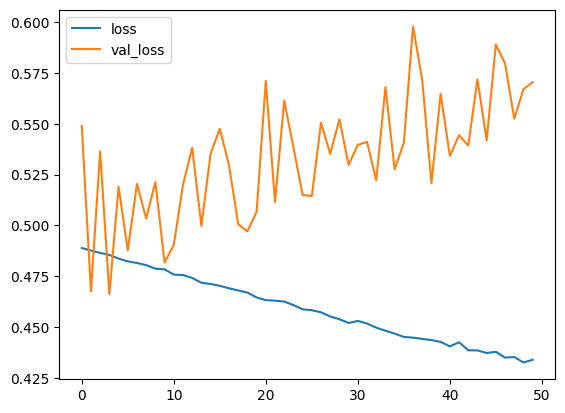

In [24]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [27]:
predictions = model.predict(test_ds)
binary_predictions = tf.round(predictions).numpy().flatten()
print(classification_report(y_test, binary_predictions))

1000/1000 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.66      0.77     29200
           1       0.09      0.33      0.14      2780

    accuracy                           0.63     31980
   macro avg       0.50      0.50      0.45     31980
weighted avg       0.84      0.63      0.71     31980



In [28]:
# observe class imbalance
neg, pos = np.bincount(y_train)
print("No.negative samples before undersampling",neg)
print("No.positive samples before undersampling",pos)

No.negative samples before undersampling 233923
No.positive samples before undersampling 21913


In [30]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
y_train = train.pop('target')
X_train = train
y_val = val.pop('target')
X_val = val
y_test = test.pop('target')
X_test = test
print("Training sample:",len(y_train))
print("Testing sample:", len(y_test))
print("Validation sample:",len(y_val))

Training sample: 255836
Testing sample: 31980
Validation sample: 31979


In [31]:
# observe class imbalance
neg, pos = np.bincount(y_train)
print("No.negative samples before undersampling",neg)
print("No.positive samples before undersampling",pos)

No.negative samples before undersampling 233933
No.positive samples before undersampling 21903


In [32]:
# resample via undersampling majority class - this is favoured over oversampling as the dataset is very large
rus = RandomUnderSampler(random_state=0)
rus.fit(X,y)
# only resample training dataset
X_train_resampled, y_train_resampled = rus.fit_resample(X_train,y_train)

neg0, pos0 = np.bincount(y_train_resampled)
print("No.negative samples after undersampling",neg0)
print("No.positive samples after undersampling",pos0)

No.negative samples after undersampling 21903
No.positive samples after undersampling 21903


In [35]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.6*len(dataframe)), int(0.9*len(dataframe))])
y_train = train.pop('target')
X_train = train
y_val = val.pop('target')
X_val = val
y_test = test.pop('target')
X_test = test
print("Training sample:",len(y_train))
print("Testing sample:", len(y_test))
print("Validation sample:",len(y_val))

Training sample: 191877
Testing sample: 31980
Validation sample: 95938


In [36]:
# resample via undersampling majority class - this is favoured over oversampling as the dataset is very large
rus = RandomUnderSampler(random_state=0)
rus.fit(X,y)
# only resample training dataset
X_train_resampled, y_train_resampled = rus.fit_resample(X_train,y_train)
X_val_resampled, y_val_resampled = rus.fit_resample(X_val, y_val)
neg0, pos0 = np.bincount(y_train_resampled)
print("No.negative samples after undersampling",neg0)
print("No.positive samples after undersampling",pos0)

print(len(y_val_resampled))

No.negative samples after undersampling 16438
No.positive samples after undersampling 16438
16438


In [37]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.6*len(dataframe)), int(0.9*len(dataframe))])
y_train = train.pop('target')
X_train = train
y_val = val.pop('target')
X_val = val
y_test = test.pop('target')
X_test = test
print("Training sample:",len(y_train))
print("Testing sample:", len(y_test))
print("Validation sample:",len(y_val))

Training sample: 191877
Testing sample: 31980
Validation sample: 95938


In [38]:
# resample via undersampling majority class - this is favoured over oversampling as the dataset is very large
rus = RandomUnderSampler(random_state=0)
rus.fit(X,y)
# only resample training dataset
X_train_resampled, y_train_resampled = rus.fit_resample(X_train,y_train)
X_val_resampled, y_val_resampled = rus.fit_resample(X_val, y_val)
neg0, pos0 = np.bincount(y_train_resampled)
print("No.negative samples after undersampling",neg0)
print("No.positive samples after undersampling",pos0)
print(len(y_train_resampled))
print(len(y_val_resampled))

No.negative samples after undersampling 16448
No.positive samples after undersampling 16448
32896
16404


In [39]:
def df_to_dataset(features, labels, batch_size=32, resample=False):
    tf_dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels)).cache()
    shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
    return shuffled_tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [40]:
def get_normalization_layer(feature_name, dataset, batch_size=32):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    #feature_data = dataset[feature_name]
    feature_data = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_data, batch_size=batch_size)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None, batch_size=32):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    #feature_ds = dataset[feature_name]
    feature_data = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_data, batch_size=batch_size)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [41]:
train_resampled_ds= df_to_dataset(X_train_resampled, y_train_resampled)
val_ds= df_to_dataset(X_val_resampled, y_val_resampled)
test_ds= df_to_dataset(X_test, y_test)

In [42]:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=train_resampled_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=train_resampled_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [43]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [46]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_resampled_ds,
                    validation_data=val_ds, 
                    epochs=20,
                    verbose=1)

Epoch 1/20
1028/1028 [==============================] - 5s 4ms/step - loss: 0.4641 - accuracy: 0.7787 - val_loss: 0.5021 - val_accuracy: 0.7569
Epoch 2/20
1028/1028 [==============================] - 4s 3ms/step - loss: 0.4614 - accuracy: 0.7809 - val_loss: 0.5048 - val_accuracy: 0.7588
Epoch 3/20
1028/1028 [==============================] - 6s 6ms/step - loss: 0.4590 - accuracy: 0.7816 - val_loss: 0.5048 - val_accuracy: 0.7580
Epoch 4/20
1028/1028 [==============================] - 5s 5ms/step - loss: 0.4580 - accuracy: 0.7824 - val_loss: 0.5074 - val_accuracy: 0.7575
Epoch 5/20
1028/1028 [==============================] - 4s 3ms/step - loss: 0.4571 - accuracy: 0.7830 - val_loss: 0.5111 - val_accuracy: 0.7555
Epoch 6/20
1028/1028 [==============================] - 5s 5ms/step - loss: 0.4545 - accuracy: 0.7835 - val_loss: 0.5105 - val_accuracy: 0.7559
Epoch 7/20
1028/1028 [==============================] - 5s 5ms/step - loss: 0.4531 - accuracy: 0.7835 - val_loss: 0.5111 - val_accuracy:

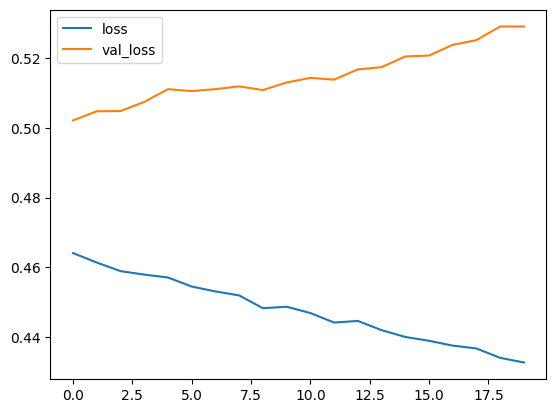

In [47]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [48]:
predictions = model.predict(test_ds)
binary_predictions = tf.round(predictions).numpy().flatten()
print(classification_report(y_test, binary_predictions))

1000/1000 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.68      0.78     29257
           1       0.08      0.30      0.13      2723

    accuracy                           0.65     31980
   macro avg       0.50      0.49      0.45     31980
weighted avg       0.84      0.65      0.73     31980



In [49]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=214, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=214, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [50]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_resampled_ds,
                    validation_data=val_ds, 
                    epochs=10,
                    verbose=1)

Epoch 1/10
1028/1028 [==============================] - 12s 8ms/step - loss: 0.5141 - accuracy: 0.7507 - val_loss: 0.5022 - val_accuracy: 0.7605
Epoch 2/10
1028/1028 [==============================] - 5s 5ms/step - loss: 0.4963 - accuracy: 0.7629 - val_loss: 0.5033 - val_accuracy: 0.7592
Epoch 3/10
1028/1028 [==============================] - 7s 7ms/step - loss: 0.4915 - accuracy: 0.7678 - val_loss: 0.4971 - val_accuracy: 0.7616
Epoch 4/10
1028/1028 [==============================] - 8s 7ms/step - loss: 0.4894 - accuracy: 0.7672 - val_loss: 0.4954 - val_accuracy: 0.7606
Epoch 5/10
1028/1028 [==============================] - 8s 7ms/step - loss: 0.4874 - accuracy: 0.7690 - val_loss: 0.4985 - val_accuracy: 0.7599
Epoch 6/10
1028/1028 [==============================] - 8s 7ms/step - loss: 0.4877 - accuracy: 0.7682 - val_loss: 0.4974 - val_accuracy: 0.7598
Epoch 7/10
1028/1028 [==============================] - 7s 6ms/step - loss: 0.4860 - accuracy: 0.7694 - val_loss: 0.4957 - val_accuracy

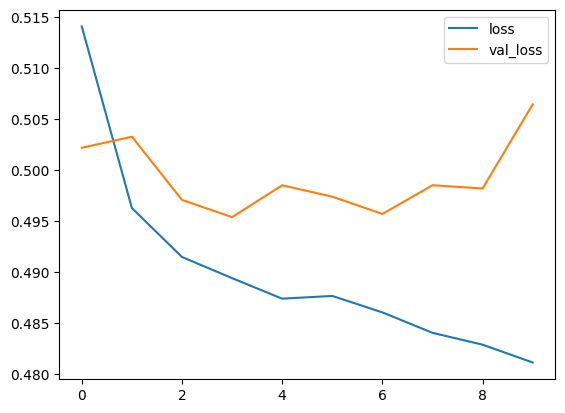

In [51]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [52]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
# x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=214, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.05)(x)
x = tf.keras.layers.Dense(units=214, activation="relu")(x)
# x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [53]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_resampled_ds,
                    validation_data=val_ds, 
                    epochs=10,
                    verbose=1)

Epoch 1/10
1028/1028 [==============================] - 12s 8ms/step - loss: 0.5045 - accuracy: 0.7574 - val_loss: 0.4990 - val_accuracy: 0.7591
Epoch 2/10
1028/1028 [==============================] - 12s 12ms/step - loss: 0.4909 - accuracy: 0.7653 - val_loss: 0.5016 - val_accuracy: 0.7594
Epoch 3/10
1028/1028 [==============================] - 13s 12ms/step - loss: 0.4858 - accuracy: 0.7676 - val_loss: 0.5038 - val_accuracy: 0.7562
Epoch 4/10
1028/1028 [==============================] - 12s 11ms/step - loss: 0.4847 - accuracy: 0.7694 - val_loss: 0.4976 - val_accuracy: 0.7581
Epoch 5/10
1028/1028 [==============================] - 7s 6ms/step - loss: 0.4816 - accuracy: 0.7709 - val_loss: 0.4991 - val_accuracy: 0.7602
Epoch 6/10
1028/1028 [==============================] - 7s 7ms/step - loss: 0.4795 - accuracy: 0.7716 - val_loss: 0.5043 - val_accuracy: 0.7587
Epoch 7/10
1028/1028 [==============================] - 7s 7ms/step - loss: 0.4760 - accuracy: 0.7735 - val_loss: 0.5016 - val_ac

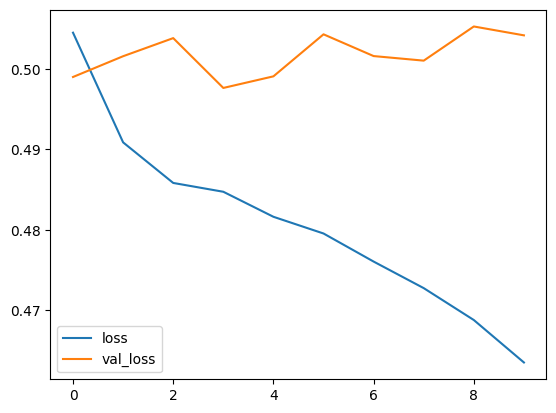

In [54]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [55]:
def df_to_dataset(features, labels, batch_size=512, resample=False):
    tf_dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels)).cache()
    shuffled_tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
    return shuffled_tf_dataset.batch(batch_size).prefetch(2)# returning 32 samples per batch

In [56]:
def get_normalization_layer(feature_name, dataset, batch_size=32):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    #feature_data = dataset[feature_name]
    feature_data = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_data, batch_size=batch_size)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None, batch_size=32):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    #feature_ds = dataset[feature_name]
    feature_data = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_data, batch_size=batch_size)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [57]:
train_resampled_ds= df_to_dataset(X_train_resampled, y_train_resampled)
val_ds= df_to_dataset(X_val_resampled, y_val_resampled)
test_ds= df_to_dataset(X_test, y_test)

In [58]:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=train_resampled_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=train_resampled_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [59]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
# x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=214, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.05)(x)
x = tf.keras.layers.Dense(units=214, activation="relu")(x)
# x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [60]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_resampled_ds,
                    validation_data=val_ds, 
                    epochs=100,
                    verbose=1)

Epoch 1/100
65/65 [==============================] - 3s 21ms/step - loss: 0.5317 - accuracy: 0.7365 - val_loss: 0.4995 - val_accuracy: 0.7579
Epoch 2/100
65/65 [==============================] - 1s 13ms/step - loss: 0.4890 - accuracy: 0.7651 - val_loss: 0.4971 - val_accuracy: 0.7601
Epoch 3/100
65/65 [==============================] - 1s 14ms/step - loss: 0.4838 - accuracy: 0.7695 - val_loss: 0.5009 - val_accuracy: 0.7543
Epoch 4/100
65/65 [==============================] - 1s 13ms/step - loss: 0.4825 - accuracy: 0.7700 - val_loss: 0.4960 - val_accuracy: 0.7567
Epoch 5/100
65/65 [==============================] - 1s 13ms/step - loss: 0.4804 - accuracy: 0.7718 - val_loss: 0.5060 - val_accuracy: 0.7562
Epoch 6/100
65/65 [==============================] - 1s 13ms/step - loss: 0.4767 - accuracy: 0.7728 - val_loss: 0.5060 - val_accuracy: 0.7549
Epoch 7/100
65/65 [==============================] - 1s 13ms/step - loss: 0.4744 - accuracy: 0.7740 - val_loss: 0.5010 - val_accuracy: 0.7578
Epoch 

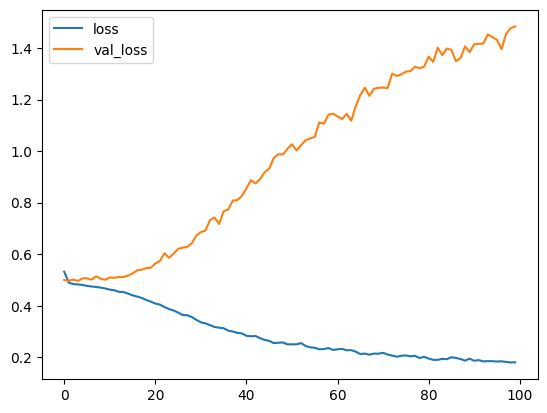

In [61]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [62]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=214, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=214, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [63]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_resampled_ds,
                    validation_data=val_ds, 
                    epochs=100,
                    verbose=1)

Epoch 1/100
65/65 [==============================] - 3s 23ms/step - loss: 0.5805 - accuracy: 0.6961 - val_loss: 0.5107 - val_accuracy: 0.7565
Epoch 2/100
65/65 [==============================] - 1s 16ms/step - loss: 0.5173 - accuracy: 0.7496 - val_loss: 0.5016 - val_accuracy: 0.7601
Epoch 3/100
65/65 [==============================] - 1s 15ms/step - loss: 0.5071 - accuracy: 0.7566 - val_loss: 0.5020 - val_accuracy: 0.7619
Epoch 4/100
65/65 [==============================] - 1s 15ms/step - loss: 0.5006 - accuracy: 0.7622 - val_loss: 0.5001 - val_accuracy: 0.7603
Epoch 5/100
65/65 [==============================] - 1s 14ms/step - loss: 0.4974 - accuracy: 0.7636 - val_loss: 0.4985 - val_accuracy: 0.7602
Epoch 6/100
65/65 [==============================] - 1s 14ms/step - loss: 0.4971 - accuracy: 0.7643 - val_loss: 0.5013 - val_accuracy: 0.7604
Epoch 7/100
65/65 [==============================] - 1s 14ms/step - loss: 0.4924 - accuracy: 0.7671 - val_loss: 0.5004 - val_accuracy: 0.7596
Epoch 

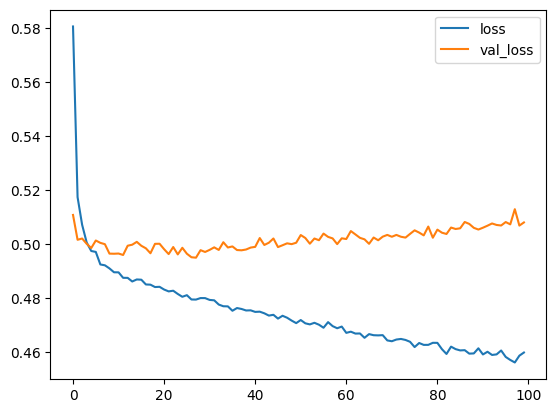

In [64]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [65]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=64, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=128, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [66]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_resampled_ds,
                    validation_data=val_ds, 
                    epochs=100,
                    verbose=1)

Epoch 1/100
65/65 [==============================] - 3s 18ms/step - loss: 0.6095 - accuracy: 0.6683 - val_loss: 0.5262 - val_accuracy: 0.7427
Epoch 2/100
65/65 [==============================] - 1s 11ms/step - loss: 0.5382 - accuracy: 0.7392 - val_loss: 0.5117 - val_accuracy: 0.7557
Epoch 3/100
65/65 [==============================] - 1s 12ms/step - loss: 0.5164 - accuracy: 0.7540 - val_loss: 0.5021 - val_accuracy: 0.7603
Epoch 4/100
65/65 [==============================] - 1s 13ms/step - loss: 0.5098 - accuracy: 0.7578 - val_loss: 0.5013 - val_accuracy: 0.7605
Epoch 5/100
65/65 [==============================] - 1s 12ms/step - loss: 0.5035 - accuracy: 0.7619 - val_loss: 0.5007 - val_accuracy: 0.7614
Epoch 6/100
65/65 [==============================] - 1s 11ms/step - loss: 0.5014 - accuracy: 0.7609 - val_loss: 0.4997 - val_accuracy: 0.7620
Epoch 7/100
65/65 [==============================] - 1s 11ms/step - loss: 0.4993 - accuracy: 0.7631 - val_loss: 0.5039 - val_accuracy: 0.7591
Epoch 

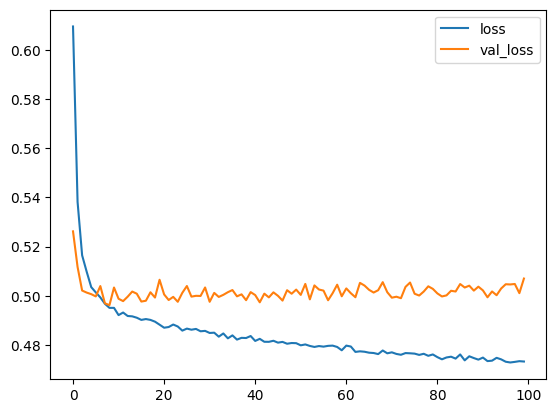

In [67]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [68]:
train_resampled_ds= df_to_dataset(X_train_resampled, y_train_resampled)
#val_ds= df_to_dataset(X_val_resampled, y_val_resampled)
val_ds = df_to_dataset(X_val, y_val)
test_ds= df_to_dataset(X_test, y_test)

In [69]:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=train_resampled_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    
    # declare header as a keras Input
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    # get preprocessing layer 
    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=train_resampled_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [70]:
# KERAS FUNCTIONAL API - MODEL BUILD   
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=64, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=128, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [71]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_resampled_ds,
                    validation_data=val_ds, 
                    epochs=100,
                    verbose=1)

Epoch 1/100
65/65 [==============================] - 5s 59ms/step - loss: 0.6203 - accuracy: 0.6526 - val_loss: 0.4976 - val_accuracy: 0.7389
Epoch 2/100
65/65 [==============================] - 3s 42ms/step - loss: 0.5409 - accuracy: 0.7384 - val_loss: 0.4830 - val_accuracy: 0.7327
Epoch 3/100
65/65 [==============================] - 3s 45ms/step - loss: 0.5199 - accuracy: 0.7526 - val_loss: 0.4801 - val_accuracy: 0.7233
Epoch 4/100
65/65 [==============================] - 3s 37ms/step - loss: 0.5111 - accuracy: 0.7578 - val_loss: 0.4770 - val_accuracy: 0.7103
Epoch 5/100
65/65 [==============================] - 3s 37ms/step - loss: 0.5045 - accuracy: 0.7579 - val_loss: 0.5018 - val_accuracy: 0.7069
Epoch 6/100
65/65 [==============================] - 3s 37ms/step - loss: 0.5016 - accuracy: 0.7612 - val_loss: 0.4958 - val_accuracy: 0.7076
Epoch 7/100
65/65 [==============================] - 3s 37ms/step - loss: 0.4990 - accuracy: 0.7604 - val_loss: 0.5014 - val_accuracy: 0.7044
Epoch 

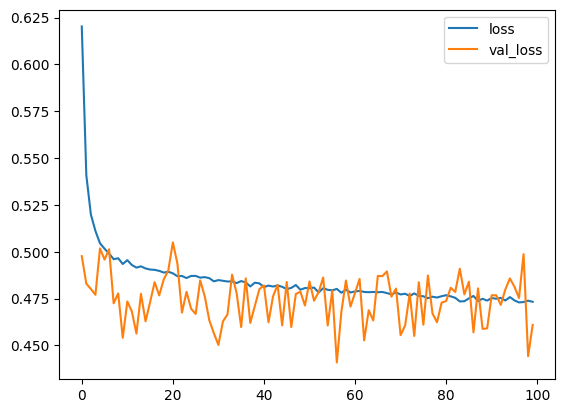

In [72]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [73]:
predictions = model.predict(test_ds)
binary_predictions = tf.round(predictions).numpy().flatten()
print(classification_report(y_test, binary_predictions))

63/63 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.92      0.72      0.81     29257
           1       0.09      0.28      0.13      2723

    accuracy                           0.68     31980
   macro avg       0.50      0.50      0.47     31980
weighted avg       0.84      0.68      0.75     31980

